In [1]:
# Suggested imports. You may add your own here.

%matplotlib inline

import collections
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\davca\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Loading Drive Folder
import os
from google.colab import drive

if(os.getcwd() != "/content/drive/MyDrive/nlp"):
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/nlp/

Mounted at /content/drive
/content/drive/MyDrive/nlp


# Text compression assignment

It is said that you can measure the intelligence of an AI from the amount it can compress a text without information loss.
One way to think about this is that, the more a text is predictable, the more words we can leave out of it as we can guess the missing words.
On the other hand, the more intelligent an AI is, the more it will find texts to be predictable and so the more words it can leave out and guess.
This has led to a competition called the [Hutter Prize](http://prize.hutter1.net/) where the objective is to compress a given text as much as possible.
The record for compressing a 1GB text file extracted from a Wikipedia snapshot is about 115MB.
The main hurdle here is that the program used to decompress the file must be treated as part of the compressed file, meaning that the program itself must also be small.

In this assignment, you're going to be doing something similar using a smaller text file and using neural language models to guess missing words.

## 1) Data processing (10%)

You have a train/dev/test split corpus of text from Wikipedia consisting of single sentences.
Each sentence is on a separate line and each sentence has been tokenised for you such that tokens are space separated.
This means that you only need to split by space to get the tokens.
The text has all been lowercased as well.
The objective here is to be able to compress the text losslessly, meaning that it can be decompressed back to the original string:

$$\text{decompress}(\text{compress}(t)) = t$$

Do not do any further pre-processing on the text (such as stemming) as it may result in unrecoverable information loss.
The test set is what we will be compressing and will not be processed at all as it will be treated as a single big string by the compression/decompression algorithms.

Do the following tasks:

### 1.1) Load the train set and dev set text files into a list of sentences where each sentence is tokenised (by splitting by space).

Do not load the test set.

In [2]:
trainText = "train.txt"
devText = "dev.txt"

def loadFileAndTokenize(textFile):
    tokensList = []
    with open(textFile, "r") as file:
        for line in file:
            tokensList.append(line.split())
    return tokensList

trainSet = loadFileAndTokenize(trainText)
devSet = loadFileAndTokenize(devText)

### 1.2) Extract a vocabulary consisting of the tokens that occur at least 3 times in the train set and output the size of your vocabulary.


Also output the most frequent vocabulary token in the train set, which should be 'the'.
Include the edge token, unknown token, and pad token in the vocabulary.

In [3]:
EDGETOKEN, UNKNOWNTOKEN, PADTOKEN = "<EDGE>", "<UNKN>", "<PAD>"

def getVocabularyAndCounts(dataSet):
    vocabularyCountPairs = {}
    for sentence in dataSet:
        for word in sentence:
            if word not in vocabularyCountPairs:
                vocabularyCountPairs[word] = 1
            else:
                vocabularyCountPairs[word] += 1

    # Vocabulary
    vocab = []
    for word in vocabularyCountPairs:
        if vocabularyCountPairs[word] >=3:
            vocab.append(word)

    for token in [EDGETOKEN, UNKNOWNTOKEN, PADTOKEN]:
        vocab.append(token)

    # Most Common Word
    mostCommonWord, score = "", 0
    for word in vocabularyCountPairs:
        if vocabularyCountPairs[word] > score:
            mostCommonWord = word
            score = vocabularyCountPairs[word]

    return vocab, mostCommonWord

vocab, mostCommonWord = getVocabularyAndCounts(trainSet)

### 1.3) Process the loaded token sequences for the train set and dev set using the vocabulary created above in a way that is suitable for a language model, making use of edge tokens, unknown tokens, and pad tokens.


Do not do this for the test set as well.

In [4]:
def processSetsWithTokens(set):
    # Add EDGE tokens
    edgeSet = []
    for sentence in set:
        sentence = [EDGETOKEN] + sentence + [EDGETOKEN]
        edgeSet.append(sentence)

    # Replace with UNKN
    unknownSet = []
    for sentence in edgeSet:
        temp = []
        for word in sentence:
            if word in vocab:
                temp.append(word)
            else:
                temp.append(UNKNOWNTOKEN)
        unknownSet.append(temp)

    # Add PAD tokens
    padSet = []
    longestTokens = 0
    for sentence in unknownSet:
        if len(sentence) > longestTokens:
            longestTokens = len(sentence)

    for sentence in unknownSet:
        if len(sentence) < longestTokens:
            numberOfTokens = longestTokens-len(sentence)

            paddedSentence = []
            paddedSentence += sentence
            for count in range(numberOfTokens):
                paddedSentence.append(PADTOKEN)

            padSet.append(paddedSentence)
        else:
            padSet.append(sentence)
    return padSet

processedTrainSet = processSetsWithTokens(trainSet)

print(processedTrainSet[0])

# processedDevSet = processSetsWithTokens(devSet)

['<EDGE>', 'dr.', '<UNKN>', 'mcdonald', 'is', 'a', 'life', 'long', '<UNKN>', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.', '<EDGE>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


In [5]:
print(trainSet[0])

['dr.', 'tonie', 'mcdonald', 'is', 'a', 'life', 'long', 'levittown', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.']


### 1.4) Finally, load the test set text file as single string and keep it in a variable.

In [6]:
testSet = ""
with open("test.txt", "r") as file:
    testSet = file.read()[:-1]

## 2) Evaluation tools (10%)

We're going to need a function that evaluates our language models as well as a way to test this function before we make the language model.
To test the evaluation function, you need to make a mock model which can be used exactly like a language model but that works with some simple rules.
This mock model will then be used to check the evaluation, compression, and decompression functions before we've developed the language model.

In this assignment, a language model function assumes the following signature:

* A parameter `x_indexes` being a tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
    The tensor is of type `int64` with shape `(batch size, time steps)`.
* Returns a tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.

Do the following tasks:

### 2.1) Develop a mock language model.

This language model will be a module that predicts the next token after every token using these rules:

* If the actual previous token (not the predicted one) was 'the' then predict that the current token is 'dog'.
* Otherwise, predict that the current token is 'the'.

Remember that it is logits that will be returned by the forward function, not probabilities.
**Give the token being predicted a logit of 2 and all other tokens a logit of 0.**
The name of this class should be `MockModel`.

Hints:

* Feel free to use `for` loops and `if` statements.
* Remember that `x_indexes` is a tensor of previous tokens.
    For example, if `x_indexes` is `[[1, 3]]`, this is saying that the first token to predict has a previous token being 1 and the second token to predict has a previous token being 3.

Some test code has been provided to check that your mock model is correct.
Fix the test code as instructed in the comments.

In [7]:
class MockModel(torch.nn.Module):
    def __init__(self, vocabSize, edgeIndex, theIndex, dogIndex):
        super(MockModel, self).__init__()
        self.vocabSize = vocabSize
        self.edgeIndex = edgeIndex
        self.theIndex = theIndex
        self.dogIndex = dogIndex

    def forward(self, xIndexes):
        batchSize, timeSteps = xIndexes.size()
        logits = torch.zeros((batchSize, timeSteps, self.vocabSize), dtype=torch.float32)

        for i in range(batchSize):
            for j in range(timeSteps):
                prevToken = xIndexes[i, j]
                if (prevToken==self.theIndex): logits[i, j, self.dogIndex] = 2
                if (prevToken!=self.theIndex): logits[i, j, self.theIndex] = 2

        return logits

In [8]:
vocabSize = len(vocab)
edgeIndex, theIndex, dogIndex = vocab.index(EDGETOKEN), vocab.index("the"), vocab.index("dog")
mockModel = MockModel(vocabSize, edgeIndex, theIndex, dogIndex)

# - - - DO NOT CHANGE - - -
mockXIndexes = torch.tensor([
    [edgeIndex, dogIndex, theIndex, theIndex],
    [edgeIndex, theIndex, dogIndex, dogIndex],
], dtype=torch.int64, device=DEVICE)

mockExpectedLogits = torch.zeros((2, 4, vocabSize), dtype=torch.float32, device=DEVICE)
mockExpectedLogits[0, 0, theIndex] = 2
mockExpectedLogits[0, 1, theIndex] = 2
mockExpectedLogits[0, 2, dogIndex] = 2
mockExpectedLogits[0, 3, dogIndex] = 2
mockExpectedLogits[1, 0, theIndex] = 2
mockExpectedLogits[1, 1, dogIndex] = 2
mockExpectedLogits[1, 2, theIndex] = 2
mockExpectedLogits[1, 3, theIndex] = 2
# - - - DO NOT CHANGE - - -

mockLogits = mockModel(mockXIndexes).to(DEVICE)
assert mockLogits.shape == mockExpectedLogits.shape, 'Output shape is invalid.'
assert mockLogits.dtype == mockExpectedLogits.dtype, 'Output data type is invalid.'
assert np.unique(mockLogits.detach().cpu().numpy()).tolist() == [0.0, 2.0], 'Output has values other than 0 and 2'
assert (mockLogits == mockExpectedLogits).all(), 'Output has the the wrong logits.'
print('Correct!')

Correct!


### 2.2) Next, we need a function that measures the perplexity of a language model on the dev set.

Your function must take a model and a data set of token indexes and return the perplexity over the entire data set.

Hints:

* Don't forget that the perplexity includes the probability of the edge token at the end of the sentence.
* Don't forget to ignore pad tokens.

Use this function to find the mock model's perplexity on the dev set, which should be equal to `7062.2`.

In [9]:
# Step 1: create function to convert to indexed
def convertToIndexed(devSet):
    indexedDevSet = []
    for i in devSet:
        tokenizedSentence = []
        for j in i:
            if j != PADTOKEN:
                tokenizedSentence.append(vocab.index(j))
        indexedDevSet.append(tokenizedSentence)
    return indexedDevSet

# Step 2: get preplexity
def calculatePerplexity(model, dataset):
    indexedDataset = convertToIndexed(dataset)

    model.eval()
    totalLoss = 0
    totalTokens = 0

    with torch.no_grad():
        for sentence in indexedDataset:
            inputTensor = torch.tensor([sentence[:-1]]).to(DEVICE)
            targetTensor = torch.tensor([sentence[1:]]).to(DEVICE)

            logits = model(inputTensor).to(DEVICE)
            loss = torch.nn.functional.cross_entropy(logits.view(-1, logits.size(-1)), targetTensor.view(-1))

            totalLoss += loss.item() * len(sentence)
            totalTokens += len(sentence)

    totalLoss = torch.tensor(totalLoss).to(DEVICE)
    totalTokens = torch.tensor(totalTokens).to(DEVICE)

    perplexity = torch.exp(totalLoss/totalTokens).to(DEVICE)
    return perplexity.item()

perplexity = calculatePerplexity(mockModel, processedDevSet)
print("Perplexity: " + str(perplexity))

Perplexity: 7062.73046875


## 3) Compression and decompression (20%)

We will now write the code that makes the actual compression and decompression of a text.

The compression algorithm will work as follows:

* You have a string of text to compress called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens` and a list of corresponding token indexes called `indexes`.
* Use `model` on `indexes` to produce `predicted`, a list of predicted next tokens for every index in `indexes`.
    A predicted next token is just the most probable token according to `model`.
* If a token in `predicted` corresponds to a token in `tokens`, then that token can be predicted by the model from its previous tokens.
    In this case, we don't need to have the token written down as it can be predicted, so we replace it in `tokens` with the single letter 'X' to say that a token should be predicted here.
    If 'X' is shorter than the replaced token, then the text will become shorter.
    Since all the text in our data sets is in lowercase, there will never be an 'X' in a sentence, so we can safely use it as a flag.
* If the token isn't correctly predicted then we leave the token in the text as-is.
* After all predictable tokens in `tokens` have been replaced with an 'X', return `tokens` as a space separated string.

The decompression algorithm will work as follows:

* You have a string of compressed text called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens`.
* Go through the tokens in `tokens` from the front and stop at the first 'X'.
* Convert all the tokens before the 'X' to token indexes called `indexes`.
* Use `model` to predict what the most probable token at the end of `indexes` would be.
* Replace the 'X' in `tokens` with this most probable token.
* Repeat this for every 'X'.
* After all 'X' are replaced in `tokens`, return `tokens` as a space separated string.

Do the following tasks:

### 3.1) Start with the compression function.

The input text will consist of sentences separated by new lines and space separated tokens (just like the raw data sets).
The function should return a single string with each line in the input text being compressed.
Remember that we want a compressed text to be decompressed back into the exact original text, which means that all out-of-vocabulary tokens must be left as-is (**there must not be any unknown tokens in the output**).

Print out the result of compressing this sentence using the mock model:

`the dog bit the cat sensually .`

which should be compressed into:

`X X bit X cat sensually .`

Hints:

* You don't need to follow the algorithm described above exactly (you can use different variable names and you can use new variables).
* Don't forget that out of vocabulary tokens still need to be replaced with the unknown token when creating the token indexes.
    What you can't do is return unknown tokens in the compressed output.
* The most probable token index for all token positions at once can be found from the logits by using `.argmax(1)`.
* Do not compare the token indexes of the uncompressed sentence to the predicted token indexes as otherwise the unknown token can be considered a correct prediction.
    Instead, compare the predictions with the string tokens in the uncompressed sentence.

In [10]:
def compression(text, model):
  tokens = [EDGETOKEN] + text.split()

  model.eval()

  indexes = [vocab.index(UNKNOWNTOKEN) if token not in vocab else vocab.index(token) for token in tokens]

  # Predictions
  predicted = []
  for index in indexes:
      indexTensor = torch.tensor([[index]]).to(DEVICE)
      output = model(indexTensor)
      argmax = torch.argmax(output, dim=2)
      predicted.append(argmax.item())

  predictedTokens = []
  predictedTokens = [vocab[index] for index in predicted]

  for i in range(len(tokens)-1):
      if tokens[i+1] == predictedTokens[i]:
          tokens[i+1] = 'X'

  return " ".join(tokens[1:])

text = "the dog bit the cat sensually . the cat ate the big dog ."
compressedText = compression(text, mockModel)
print("Text:\n" + text)
print("\nCompressed Text:\n" + compressedText)

Text:
the dog bit the cat sensually . the cat ate the big dog .

Compressed Text:
X X bit X cat sensually . X cat ate X big dog .


### 3.2) Now write the decompression function.


Again, The input text will consist of sentences separated by new lines and space separated tokens, only this time, some of those tokens will be an 'X'.
The function should return a single big string where each line in the compressed text is decompressed back into the original input line.

Print out the result of decompressing the compressed text:

`X X bit X cat sensually .`

which should be decompressed into:

`the dog bit the cat sensually .`

Hints:

* You cannot use the language model once to predict all 'X's at once because the sentence prefix leading up to the 'X' must not have another 'X' in it.
    So you have to make a separate language model prediction for every 'X' using only the tokens that come before 'X' as input to the language model (plus the edge token at the front).
* Don't forget that the input to the language model cannot contain 'X's, so make sure that you're replacing those 'X's with their predicted token when constructing the language model input.


In [11]:
from IPython.display import clear_output

def decompression(text, model):
  tokens = text.split()

  model.eval()
  decompressedTokens = []

  counter = 0

  for token in tokens:
    if token == "X":
      input = [EDGETOKEN] + decompressedTokens
      indexes = [vocab.index(tok) if tok in vocab else vocab.index(UNKNOWNTOKEN) for tok in input]

      inputTensor = torch.tensor([[indexes[-1]]]).to(DEVICE)
      output = model(inputTensor)
      argmax = torch.argmax(output, dim=2)
      prediction = vocab[argmax.item()]
      decompressedTokens.append(prediction)

      clear_output()
      counter += 1; print(counter)

    else:
      decompressedTokens.append(token)

  return " ".join(decompressedTokens)

decompressedText = decompression(compressedText, mockModel)
print("Compressed Text:\n" + compressedText)
print("\nText:\n" + decompressedText)

5
Compressed Text:
X X bit X cat sensually . X cat ate X big dog .

Text:
the dog bit the cat sensually . the cat ate the big dog .


### 3.3) Next, calculate and print the space saving amount of the mock model on the test set.

The space saving amount is calculated as follows:

$$\text{space\_saving}(t) = 1 - \frac{|\text{compress}(t)|}{|t|}$$

where $|t|$ is the number of characters in text $t$.

This measure tells you what fraction of the original size has been shaved off after compression (higher is better).
The mock model should give 2.4%.

In [12]:
def calculateSpaceSaving(text, compressed):
    t, compressedT = len(text), len(compressed)
    quotient = compressedT/t
    return round((1-quotient)*100, 1)

spaceSaved = calculateSpaceSaving(testSet, compression(testSet, mockModel))
print("Space Saved: " + str(spaceSaved) + "%")

Space Saved: 2.4%


## 4) Making and using a language model (50%)

Now we finally train a language model and use it to compress the test set.

Do the following tasks:

### 4.1) Train a neural language model on the train set.

After training, show a graph of how the *dev set perplexity* varies with each epoch (use the perplexity function you wrote above).

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TextDataset(Dataset):
    def __init__ (self, vocabulary, dataset):
        self.vocab = vocabulary
        self.dataset = dataset

    def __len__ (self):
        return len(self.dataset)

    def __getitem__(self, index):
        tokens = self.dataset[index]
        tokenIndexes = []
        for token in tokens:
            tokenIndexes.append(self.vocab.index(token))
        return torch.tensor(tokenIndexes)

In [14]:
class LanguageModel(torch.nn.Module):
    def __init__(self, vocabSize, embeddingSize=1024, stateSize=1024):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocabSize, embeddingSize)
        self.rnnS0 = torch.nn.Parameter(torch.zeros((stateSize,), dtype=torch.float32))
        self.rnnC0 = torch.nn.Parameter(torch.zeros((stateSize,), dtype=torch.float32))
        self.rnnCell = torch.nn.LSTMCell(embeddingSize, stateSize)
        self.outputLayer = torch.nn.Linear(stateSize, vocabSize) # Output size is vocabulary size.

    def forward(self, inputSequence):
        batchSize = inputSequence.shape[0]
        timeSteps = inputSequence.shape[1]

        embedded = self.embedding(inputSequence)
        state = self.rnnS0[None, :].tile((batchSize, 1))
        c = self.rnnC0[None, :].tile((batchSize, 1))
        interimStates = []

        for t in range(timeSteps):
            (state, c) = self.rnnCell(embedded[:, t, :], (state, c))
            interimStates.append(state)

        interm_states = torch.stack(interimStates, dim=1)
        return self.outputLayer(interm_states)

In [15]:
import time

def trainingLoop(model, trainDataloader, devDataloader, epochs=5, learningRate=0.001):
    trainLosses = []
    devLosses = []
    devPerplexities = []

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

    for epoch in range(epochs):
        start = time.time()

        model.train()
        total_loss = 0
        for batch in trainDataloader:
            inputData = batch[:, :-1].to(DEVICE)  # Input sequence (exclude last token)
            target = batch[:, 1:].contiguous().view(-1).to(DEVICE)  # Target sequence shifted by one

            optimizer.zero_grad()
            output = model(inputData).to(DEVICE)
            output = output.view(-1, output.size(-1))

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # validation
        model.eval()
        totalDevLoss = 0
        totalTokens = 0

        with torch.no_grad():
            for batch in devDataloader:
                input_data = batch[:, :-1].to(DEVICE)
                target = batch[:, 1:].contiguous().view(-1).to(DEVICE)

                output = model(input_data).to(DEVICE)
                output = output.view(-1, output.size(-1))  # Reshape output

                dev_loss = criterion(output, target)
                totalDevLoss += dev_loss.item()
                totalTokens += target.numel()

            avg_loss = totalDevLoss / len(devDataloader)
            perplexity_score = calculatePerplexity(model, devDataloader.dataset.dataset)
            devPerplexities.append(perplexity_score)

        avg_loss = total_loss / len(trainDataloader)
        avg_dev_loss = totalDevLoss / len(devDataloader)
        trainLosses.append(avg_loss)
        devLosses.append(avg_dev_loss)

        end = time.time()

        print(f"Epoch: {epoch+1}\tTrain Loss: {avg_loss}\tDev Loss: {avg_dev_loss}\tPerplexity: {perplexity_score}\tTime Taken: {end-start}")

    plt.figure(figsize=(8, 6))
    plt.plot(devPerplexities, label='Dev Perplexity')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title('Dev Set Perplexity vs. Epochs')
    plt.legend()
    plt.show()

    # plotting the graph
    plt.figure(figsize=(8, 6))
    plt.plot(trainLosses, label='Train Loss')
    plt.plot(devLosses, label='Dev Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Epochs')
    plt.legend()
    plt.show()

    return model

Epoch: 1	Train Loss: 3.3588659356280073	Dev Loss: 2.600160155977522	Perplexity: 167.44007873535156	Time Taken: 98.95203042030334
Epoch: 2	Train Loss: 2.611571201464025	Dev Loss: 2.4386885166168213	Perplexity: 121.28340911865234	Time Taken: 92.29845356941223
Epoch: 3	Train Loss: 2.431156757401257	Dev Loss: 2.353971447263445	Perplexity: 102.56967163085938	Time Taken: 91.42748212814331
Epoch: 4	Train Loss: 2.293179413167442	Dev Loss: 2.302112306867327	Perplexity: 93.5937271118164	Time Taken: 91.95285272598267
Epoch: 5	Train Loss: 2.1773797767918284	Dev Loss: 2.2715041296822682	Perplexity: 87.97017669677734	Time Taken: 93.9814841747284


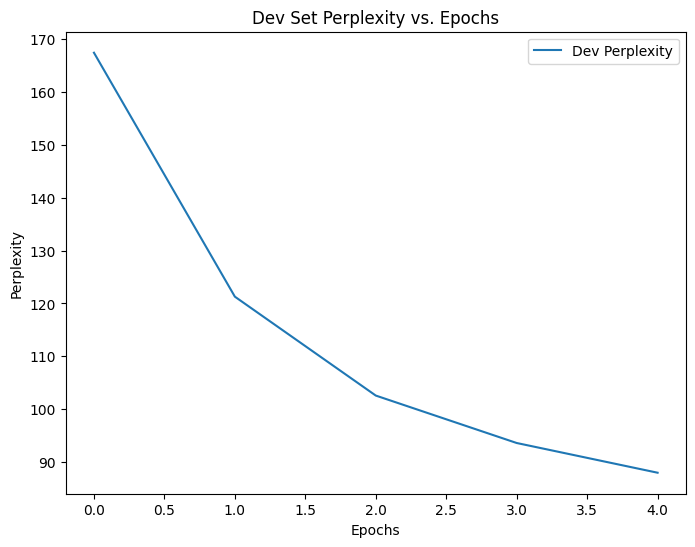

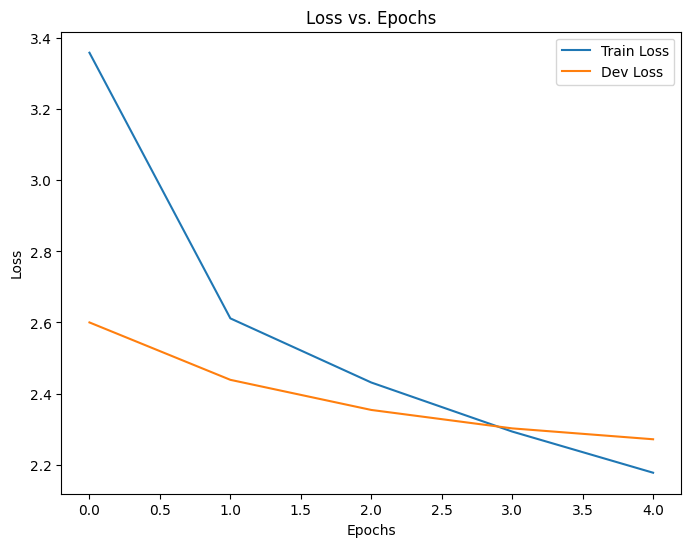

In [16]:
trainDataset = TextDataset(vocab, processedTrainSet)
devDataset = TextDataset(vocab, processedDevSet)

batchSize = 256
trainDataloader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)
devDataloader = DataLoader(devDataset, batch_size=batchSize, shuffle=True)

unTrainedmodel = LanguageModel(len(vocab)).to(DEVICE)
trainedModel = trainingLoop(unTrainedmodel, trainDataloader, devDataloader)

In [17]:
# Check if best model
def saveBestModel(model):
  spaceSaved = calculateSpaceSaving(testSet, compression(testSet, model))

  bestModel = LanguageModel(len(vocab)).to(DEVICE)
  bestModel.load_state_dict(torch.load("bestModel.pt"))
  spaceSavedBest = calculateSpaceSaving(testSet, compression(testSet, bestModel))

  if spaceSaved > spaceSavedBest:
    torch.save(model.state_dict(), 'bestModel.pt')
  torch.save(model.state_dict(), "lastModel.pt")

saveBestModel(trainedModel)

In [18]:
# Comment/Uncomment depending on if you want to use the last model trained or the best model trained
runModel = LanguageModel(len(vocab)).to(DEVICE)
# runModel.load_state_dict(torch.load("bestModel.pt"))
runModel.load_state_dict(torch.load("lastModel.pt"))

<All keys matched successfully>

### 4.2) Now measure the space saving amount of the trained model on the test text.

Also check that when you decompress the compressed test text, you get exactly the same string as the test text.

Note: You may need to strip off the new line character from the end of the test text when comparing it to the decompressed text.

In [19]:
spaceSaved = calculateSpaceSaving(testSet, compression(testSet, runModel))
print("Space Saved: " + str(spaceSaved) + "%")

Space Saved: 2.5%


In [20]:
# Compress
start = time.time()
compressedTest = compression(testSet, runModel)
print(f"Compressed Completed ({time.time()-start})")

# Get number of compressed tokens
counter = 0
for token in compressedTest.split():
  if token == "X": counter += 1

# Decompress
total = counter
start = time.time()
decompressedTest = decompression(compressedTest, runModel)
print(f"Decompressed Completed ({time.time()-start})")

# Check if match
testSetOneLine = testSet.replace("\n", " ")
if testSetOneLine == decompressedTest:
  print("Match!")
else:
  print("No Match!")

4018
Decompressed Completed (5667.0305869579315)
Match!


### 4.3) Now you need to analyse the model's output.

Split the test text into sentences and compress each individual sentence.
Print out the top 5 most compressed sentences and the top 5 least compressed sentences according to the space saving metric together with the compressed sentences.

In [21]:
sentenceSpaceSavingPairs = {}

testSetSplit = testSet.split("\n")
for sentence in testSetSplit:
  compressedSentence = compression(sentence, runModel)
  sentenceSpaceSavingPairs[sentence] = calculateSpaceSaving(sentence, compressedSentence)

# Getting the Top Five
def getTopFive(sentenceDict):
  topFive = []
  for number in range(5):
    maxNum = 0
    maxSentence = ""

    for sentence in sentenceDict:
      if sentenceDict[sentence] > maxNum:
        maxNum = sentenceDict[sentence]; maxSentence = sentence

    topFive.append((maxSentence, maxNum))
    sentenceDict.pop(maxSentence)
  return topFive

topFive = getTopFive(sentenceSpaceSavingPairs)
print("Top Five Space Saving Sentences")
for i in topFive:
  print(f"Sentence:\t\t{i[0]}")
  print(f"Compressed Sentence:\t{compression(i[0], runModel)}")
  print(f"Space Saved:\t\t{i[1]}%")
  print()

# Getting the Bottom Five
def getBottomFive(sentenceDict):
  bottomFive = []
  for number in range(5):
    minNum = 101
    minSentence = ""
    for sentence in sentenceDict:
      if sentenceDict[sentence] < minNum:
        minNum = sentenceDict[sentence]; minSentence = sentence
    bottomFive.append((minSentence, minNum))
    sentenceDict.pop(minSentence)
  return bottomFive

bottomFive = getBottomFive(sentenceSpaceSavingPairs)
print("\nBottom Five Space Saving Sentences")
for i in bottomFive:
  print(f"Sentence:\t\t{i[0]}")
  print(f"Compressed Sentence:\t{compression(i[0], runModel)}")
  print(f"Space Saved:\t\t{i[1]}%")
  print()

Top Five Space Saving Sentences
Sentence:		the per capita income for the county was $ 1 7 , 3 1 2 .
Compressed Sentence:	X per X X X X county was $ 1 7 , 3 1 2 .
Space Saved:		28.6%

Sentence:		she won a gold medal at the 2 0 1 6 summer olympics in the women 's 6 9 kg category .
Compressed Sentence:	she won a gold X X X 2 X 1 6 summer X X X women X 6 9 kg category .
Space Saved:		21.2%

Sentence:		on june 1 3 , 1 9 7 2 , it was added to the united states national register of historic places .
Compressed Sentence:	on june 1 3 , 1 X 7 2 , it was added to X united X national X X historic X .
Space Saved:		20.8%

Sentence:		he competed in the individual foil events at the 2 0 1 2 summer olympics , 2 0 0 8 summer olympics and 2 0 0 4 summer olympics .
Compressed Sentence:	he competed X X individual foil events at X 2 X 1 2 summer X , 2 X X 8 summer X and 2 X X 4 summer X .
Space Saved:		20.3%

Sentence:		there were 4 5 2 housing units at an average density of .
Compressed Sentence:	there we

### 4.4) Is the reason for whether a sentence is compressible or not due to its similarity to the train set (a sentence that is similar to one in the train set would be easier to predict and thus more tokens will be compressed)?

Find out the answer to this by doing the following:

Extract all the trigrams from the train set (you can use `nltk.trigrams` to do this).
For each sentence in the test set, count how many of its trigrams are also found in the train set.
Turn this count into a domain similarity measure by dividing it by the number of trigrams in the test sentence.

Note: In order for this fraction to be meaningful from the language model's point of view, the edge token must be added to the front of the test sentences and out-of-vocabulary tokens must be replaced with the unknown token.

Create a list that maps each sentence's domain similarity to its space saving amount.
Plot a scatter plot showing how the domain similarity measure relates to the space saving amount of each test sentence.
If there is a correlation between these two measures, then the points in the scatter plot will form approximately into a straight line.

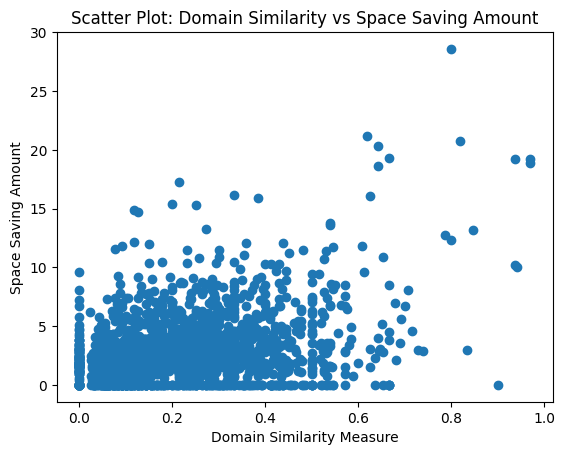

In [22]:
trainSetOneLine = ""
for sentence in trainSet:
  trainSetOneLine += (" ".join(sentence)) + " "
trainTrigrams = set(nltk.trigrams(trainSetOneLine.split()))

domainSimilarity = []
spaceSaving = []

for sentence in testSet.split("\n"):
  # Add Edge Token
  sentenceSplit = [EDGETOKEN] + sentence.split()

  # Replace to Unknown Tokens
  for token in sentenceSplit:
    if token not in vocab:
      sentenceSplit[sentenceSplit.index(token)] = UNKNOWNTOKEN

  testTrigrams = set(nltk.trigrams(sentenceSplit))

  commonTrigramCount = sum(1 for trigram in testTrigrams if trigram in trainTrigrams)
  similarityMeasure = commonTrigramCount / len(testTrigrams)

  domainSimilarity.append(similarityMeasure)
  spaceSaving.append(calculateSpaceSaving(sentence, compression(sentence, runModel)))

plt.scatter(domainSimilarity, spaceSaving)
plt.title('Scatter Plot: Domain Similarity vs Space Saving Amount')
plt.xlabel('Domain Similarity Measure')
plt.ylabel('Space Saving Amount')
plt.show()

### 4.5) The scatter plot should not have created a straight line and should show a lot of bias towards very low space saving amounts, regardless of domain similarity.

Why is domain similarity not enough for explaining the compressability?

In [23]:
# Domain similarity alone does not sufficiently explain text compressibility because compressing text involves considerations beyond
# shared topics. Linguistic complexity, redundancy, contextual dependencies, ambiguity, cultural references, personalization, and
# creative expression all contribute to the intricacies of language that affect compressibility. Effective compression relies on
# capturing and leveraging these diverse factors, making it a complex interplay of linguistic nuances and not solely dependent on the
# similarity of domains or topics.

## 5) Conclusions (10%)

Write the following conclusions:

### 5.1) What is a simple change in the compression algorithm that can be made to increase compression?

Do not suggest any fundamental changes; the algorithm must still work by predicting missing tokens.

In [ ]:
# A simple change that could be applied to possibly increase the compression is reducing the size the model parameters embeddingSize and
# stateSize and increasing the number of epochs. Also, using a more complex model architecture could increase the space saving ability of
# the model

### 5.2) Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.

You should talk about things like overfitting/underfitting and whether the model is learning anything deep about English sentences.

In [ ]:
# The model learns well for five rounds but starts getting too specialized after the second one. To make it work better, we could try adjusting the model or using certain
# techniques. On average, it saves about 2.5% of space, which is a decent improvement. Some sentences even save almost 30%, showing the model is good at compressing certain
# types of information. It makes us wonder if the model really understands English and its details. As we keep studying, fixing the specialized learning and looking into how
# well the model gets English could help make better data compression tools for different uses.